# Lower bound of $\tilde\vartheta^d(G, w)$

## Method 1: seesaw algorithm based on semidefinite programming

$\tilde\vartheta^d(G, w)$ is defined as

(Eq. 1)
$$\begin{align}
\max_{X}\quad & \sum_{i=1}^n w_i X_{ii}\\
\mathrm{s.t.}\quad & X_{00} = 1, ~ X_{0i} = X_{ii},\\
& X_{ij} = 0 ~~ \text{for} ~~ \{i,j\}\in E,\\
& X \ge 0, ~ \mathrm{rank}(X) = d.
\end{align}
$$

This is equivalent to the following optimization in the limit $\eta\to+\infty$

(Eq. 2)
$$\begin{align}
\max_{X, P}\quad & \sum_{i=1}^n w_i X_{ii} - \eta \mathrm{Tr}(PX)\\
\mathrm{s.t.}\quad & X \ge 0, ~ X_{00} = 1, ~ X_{0i} = X_{ii},\\
& X_{ij} = 0 ~~ \text{for} ~~ \{i,j\}\in E,\\
& P\ge 0, ~ P^2 = P, ~ \mathrm{rank}(P) = n - d + 1.
\end{align}
$$

This can be solved by alternatingly performing the following two optimization problems

(Eq. 3)
$$\begin{align}
\max_{X}\quad & \sum_{i=1}^n w_i X_{ii} - \eta \mathrm{Tr}(P_\star X)\\
\mathrm{s.t.}\quad & X \ge 0, ~ X_{00} = 1, ~ X_{0i} = X_{ii},\\
& X_{ij} = 0 ~~ \text{for} ~~ \{i,j\}\in E.\\
\end{align}
$$

(Eq. 4)
$$\begin{align}
\max_{P}\quad & \sum_{i=1}^n w_i X_{\star ii} - \eta \mathrm{Tr}(PX_\star)\\
\mathrm{s.t.}\quad & P\ge 0, ~ P^2 = P, ~ \mathrm{rank}(P) = n - d + 1.
\end{align}
$$

In [1]:
import numpy as np
import cvxpy as cvx
import networkx as nx
import scipy.linalg as lin
from scipy.stats import unitary_group, ortho_group

w = [1. 1. 1. 1. 1. 1. 1. 1. 1.]


/tmp/ipykernel_26268/1532849509.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  G = nx.adjacency_matrix(graph, dtype=float).todense()


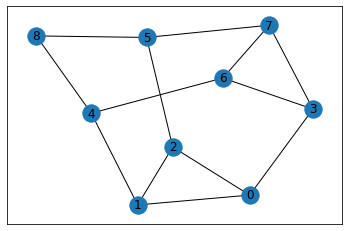

In [2]:
# Define the graph (in graph6 format)
graph = nx.from_graph6_bytes(b'H{O_okK')

# draw the graph
nx.draw_networkx(graph)


# G is the adjacency matrix
G = nx.adjacency_matrix(graph, dtype=float).todense()
#print("The adjacency matrix:\n", G)


# n is the number of vertices
n = G.shape[0]
#print("Number of vertices:", n)

# w_i
w = np.ones(n)

print("w =", w)

In [3]:
# Define the SDP

Id = np.identity(n + 1)

# resacle the parameters to make the problem DPP
# https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
eP = cvx.Parameter((n + 1, n + 1), hermitian=True) # eta * P

X = cvx.Variable((n + 1, n + 1), hermitian=True)

obj = cvx.Maximize(w @ cvx.real(cvx.diag(X)[1:]) - cvx.trace(cvx.real(eP@X)))
cons = [cvx.multiply(G, X[1:,1:]) == 0,
        X[0, 0] == 1, X[0] == cvx.diag(X),
        X >> 0]

prob = cvx.Problem(obj, cons)

In [4]:
# Implement the seesaw algorithm

# dimention to test
d = 3

# number of different initial values to try
num = 10

# eta
eta = 1

# tolerance
tol = 1e-8


eD = np.diag([eta]*(n - d + 1) + [0]*d)


for i in range(num):

    U = unitary_group.rvs(n + 1)

    eP.value = eta * U[0:n-d+1].conj().T @ U[0:n-d+1]

    err = np.inf
    val = - np.inf

    while err > tol:

        prob.solve(solver="MOSEK")

        v, U = lin.eigh(X.value)

        eP.value = U @ eD @ U.conj().T

        err = prob.value - val
        val = prob.value

        
    print("max =", val, "\tsum of the smallest n - d + 1 eigenvalues of X:", sum(v[0:n-d+1]))

max = 3.317667213808877 	sum of the smallest n - d + 1 eigenvalues of X: 1.8003179305230744e-08
max = 3.0000000045869846 	sum of the smallest n - d + 1 eigenvalues of X: 2.357995303689711e-07
max = 3.2360679694299925 	sum of the smallest n - d + 1 eigenvalues of X: 2.5711613556999732e-08
max = 3.3380444523182216 	sum of the smallest n - d + 1 eigenvalues of X: 1.7333177736208255e-09
max = 3.338044449692453 	sum of the smallest n - d + 1 eigenvalues of X: 1.7438032288020829e-09
max = 3.2360679628817097 	sum of the smallest n - d + 1 eigenvalues of X: 4.145912372984068e-08
max = 3.338044450963661 	sum of the smallest n - d + 1 eigenvalues of X: 1.7291459232091529e-09
max = 3.338044448851919 	sum of the smallest n - d + 1 eigenvalues of X: 1.7330103048697873e-09
max = 3.2360679737434803 	sum of the smallest n - d + 1 eigenvalues of X: 7.863845783841137e-09
max = 3.2360679760098052 	sum of the smallest n - d + 1 eigenvalues of X: 3.320374704057286e-08
